In [1]:
import tensorflow as tf
print('TF version: ', tf.__version__)
import glob
import cv2
from IPython import display


import matplotlib.pyplot as plt
import os, time  
import numpy as np 
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

TF version:  2.1.0


In [2]:
import image_helper_for_DCGAN as helper

data_dir = "H://PatternLab//PatternRecognition//Datasets//brain//keras_png_slices_data//keras_png_slices_train//path_test"
tf_X_train = helper.cv_get_images(data_dir)
tf_X_train.shape

print('max = ', tf.reduce_max(tf_X_train).numpy())
print('min = ', tf.reduce_min(tf_X_train).numpy())


max =  0.8901961
min =  -1.0


In [3]:
# Create train batch generator

BUFFER_SIZE = 8000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(tf_X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset


<BatchDataset shapes: (None, 128, 128, 1), types: tf.float32>

In [4]:
import DCGAN_utilities as DCGAN

2.1.0


In [5]:
# Initialise generator:

generator = DCGAN.make_generator_model()
generator.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 65536)             6553600   
_________________________________________________________________
batch_normalization (BatchNo (None, 65536)             262144    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 65536)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0

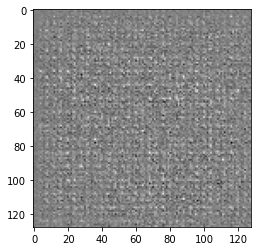

In [6]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [7]:
# Initialize discriminator

discriminator = DCGAN.make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)           

In [8]:
##defining Optimisers:
#
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [9]:
## Defnine Training Loop
#
EPOCHS = 5
noise_dim = 100
num_examples_to_generate = 16

## We will reuse this seed overtime (so it's easier)
## to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [27]:
def train_step(generator, discriminator, images, BATCH_SIZE = 128, noise_dim = 100):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    #tf.config.run_functions_eagerly(True)
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = DCGAN.generator_loss(fake_output)
        disc_loss = DCGAN.discriminator_loss(real_output, fake_output)
      

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)	

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return  (gen_loss, disc_loss)
 

def train(generator, discriminator, dataset, epochs):
    """
    Main function to train the models.
    
    returns SSIM, Generator loss and Discriminator loss
    
    """
    
    ssims = []
    gen_losses = []
    disc_losses = []
    
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            (gen_loss, disc_loss) =  train_step(generator, discriminator, image_batch)
        
        # Produce images for the GIF as we go
        
        display.clear_output(wait=True)
        DCGAN.generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)
        
        
        gen_losses.append(gen_loss.numpy())
        disc_losses.append(disc_loss.numpy())
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
        
        test_img = tf.image.convert_image_dtype(generator.predict(np.asarray(seed).reshape(16,100))[0], tf.float32, saturate=False, name=None)
        ssim = DCGAN.get_max_ssim(tf_X_train[:500],test_img)
        ssims.append(ssim)                    
        print('ssim = ', ssim)
        


    # Generate after the final epoch
    display.clear_output(wait=True)
    DCGAN.generate_and_save_images(generator,
                           epochs,
                           seed)
    
    return [ssims, gen_losses, disc_losses]


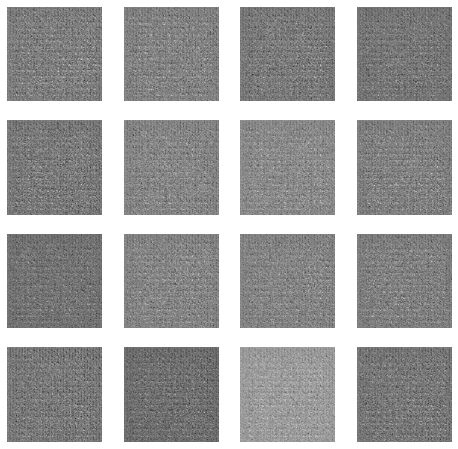

In [28]:
[ssims, gen_losses, disc_losses] = train(generator, discriminator, train_dataset, EPOCHS)


In [29]:
[ssims, gen_losses, disc_losses]

[[0.017386088, 0.017455388, 0.017510451, 0.0175501, 0.01761377],
 [0.67332685, 0.6901672, 0.7295475, 0.79044175, 0.87011015],
 [0.87917364, 0.7800959, 0.70160574, 0.6343188, 0.5643299]]